# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 8 (Transformer)*

---

**Points:** 70<br>
**Due:** 9.2.2023, 10 am<br>
**Contact:** Matthias Fulde ([fulde@cs.uni-frankfurt.de](mailto:fulde@cs.uni-frankfurt.de))<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

<br>

## Table of Contents

---

- [1 Patch Embedding](#1-Patch-Embedding-(10-Points))
- [2 Transformer Encoder](#2-Transformer-Encoder-(50-Points))
  - [2.1 Fully Connected Network](#2.1-Fully-Connected-Network-(10-Points))
  - [2.2 Absolute Position Encoding](#2.2-Absolute-Position-Encoding-(5-Points))
  - [2.3 Multihead Attention](#2.3-Multihead-Attention-(25-Points))
  - [2.4 Transformer Encoder Layer](#2.4-Transformer-Encoder-Layer-(10-Points))
- [3 Vision Transformer](#3-Vision-Transformer-(10-Points))


<br>

## Setup

---

We load the PyTorch library that allows us to perform the computations on the graphics card. You can check the GPU support of your environment with the statements below.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Additionally, we load some utility functions to calculate the number of parameters in a network, show samples from the dataset, train a model and check its accuracy.

In [2]:
from utils import num_params, show_images, check_accuracy, train

<br>

## Dataset

---

In this problem set we're working with the MNIST dataset of handwritten digits. The dataset consists of 60000 grayscale images for training and 10000 images for testing. We're loading the dataset from the PyTorch repository and split off a dataset for validation.

In [3]:
# Set number of samples per batch.
batch_size = 64

# Convert input images to tensors.
transform = T.ToTensor()

# Load and transform training set.
data_train = torchvision.datasets.MNIST(
    root='./datasets',
    train=True,
    download=True,
    transform=transform
)

# Load and transform test set.
data_test = torchvision.datasets.MNIST(
    root='./datasets',
    train=False,
    download=True,
    transform=transform
)

# Split training set into sets for training and validation.
data_train, data_val = torch.utils.data.random_split(data_train, [50000, 10000])

# Create dataloader for training set.
loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Create dataloader for validation set.
loader_val = torch.utils.data.DataLoader(
    data_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Create dataloader for test set.
loader_test = torch.utils.data.DataLoader(
    data_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    drop_last=True
)


Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw




Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw




Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw




Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw



Let's have a look at how the images in the dataset look like.

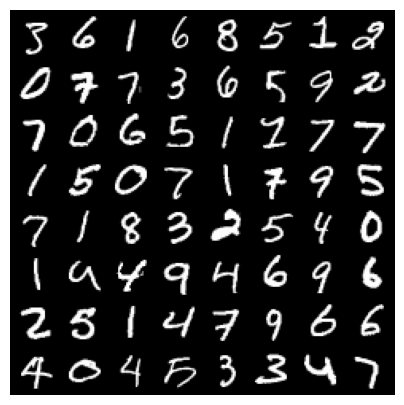

In [4]:
show_images(loader_train)

<br>

## Exercises

---

The goal in this assignment is to create a vision transformer model for classification.

<br>

### 1 Patch Embedding (10 Points)

---

Transformers work on sequential data. In particular, the model expects its input to be a sequence of vectors. Since images don't naturally fit this specification, we first have to write some code for converting an image to a sequence of feature vectors.

<br>

#### 1.1 Task

Complete the definition of the `PatchEmbed` class below.

The module should take a batch of images, represented with channels before spatial dimensions, partition each image into non-overlapping patches of size `patch_size`, and linearly project each patch into an embedding vector with the dimension `embed_dim`. Optionally, the resulting vectors should be normalized.

We assume that if a normalization module is provided, it's going to be a layer norm. Since we only want to compute the statistics across the last dimension, pass `embed_dim` to the constructor when conditionally creating an instance.

In case of grayscale images such as those from the MNIST dataset, there might not be a separate channel dimension. You should check in the `forward` method the number of dimensions of the input and if the channel dimension is missing, add a dimension of size $1$ in the second position after the batch dimension.

<br>

#### 1.2 Solution

Write your solution in the delimited areas below.

In [12]:
class PatchEmbed(nn.Module):

    def __init__(self, img_size, channels=1, patch_size=4, embed_dim=96, norm_layer=None):
        """
        Create image to patch embedding module.

        Parameters:
            - img_size (int): Image size.
            - channels (int) [1]: Number of input channels.
            - patch_size (int) [4]: Patch token size.
            - embed_dim (int) [96]: Size of embedding vectors.
            - norm_layer (nn.Module|None) [None]: Normalization layer.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Hyperparameters
        self.img_size = img_size
        self.channels = channels
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.norm_layer = norm_layer
        
        # Layers
        self.embedding = nn.Linear(patch_size*patch_size, embed_dim)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, x):
        """
        Create patch embeddings from input images.

        Parameters:
            - x (torch.Tensor): (batch_size, [channels,] height, width).

        Returns:
            - x (torch.Tensor): (batch_size, num_patches, embed_dim).

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # If there is no explicit dimension for the channel then add one
        if (len(x.shape) == 3):
            x = x.unsqueeze(dim=1)
            
        # Extrakt shape informtion
        batch_size, channels, height, width = x.shape
        
        # Flatten images
        x = x.reshape(batch_size, channels, height*width)
        
        # Split images into patches (patches will be of shape (batch_size,n_patches,channels,patch_size^2)
        # Each list items contains the same region of each image in the batch
        patches = torch.stack(torch.split(x, self.patch_size**2, dim=2), dim=1)
        
        # Embed each patch (result will be of shape (batch_size,n_patches,channels,embed_dim))
        embeddings = self.embedding(patches)
        
        # Remove channel dimension (if there is only one channel dimension)
        x = embedding.squeeze()

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return x

<br>

### 2 Transformer Encoder (50 Points)

---

For the vision transformer we're about to create, we get rid of the decoder part from the original transformer description. Our transformer network will just be a stack of encoder blocks. Each transformer encoder block is composed of two sublayers, namely a multihead self-attention sublayer and a small fully connected network with one hidden layer.

<br>

### 2.1 Fully Connected Network (10 Points)

---

Let's begin with the fully connected network for the encoder blocks.

<br>

#### 2.1.1 Task

Complete the definition of the `FullyConnectedNetwork` class below.

As mentioned above, this network consists of two layers, a hidden layer and an output layer. The dimension of the output vectors must match the dimension of the input. In order to determine the size of the intermediate vectors that are produced by the hidden layer, we use a `scale` parameter, which is multiplied with `in_features`. The result must be cast to integer before passing to the appropriate module for creating the linear layer.

The output of the hidden layer is passed through a non-linearity that is given as a module with the `activation` parameter of the constructor. The output layer is just linear, without activation. Optionally, dropout should be applied to the activations of the hidden layer and to the final output.

<br>

#### 2.1.2 Solution

Write your solution in the delimited areas below.

In [ ]:
class FullyConnectedNetwork(nn.Module):

    def __init__(self, in_features, scale=2.0, activation=nn.LeakyReLU, dropout=0.0):
        """
        Create fully connected network for transformer block.

        Parameters:
            - in_features (int): Size of input vectors.
            - scale (float) [2.0]: Scaler for size of hidden vectors.
            - activation (nn.Module) [nn.LeakyReLU]: Activation function for hidden layer.
            - dropout (float) [0.0]: Probability for dropout.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Hyperparameters
        self.in_features = in_features
        self.scale = scale
        self.hidden_size = int(in_features*scale)
        self.dropout = dropout
        
        # Layers
        self.fc1 = nn.Linear(self.in_features, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.in_features)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, x):
        """
        Compute forward pass through network.

        Parameters:
            - x (torch.Tensor): (batch_size, num_patches, in_features).

        Returns:
            - x (torch.Tensor): (batch_size, num_patches, in_features).

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Run inputs through the first layer
        x = self.dropout(self.activation(self.fc1(x)))
        # Run the hidden layer outputs through the second layer
        x = self.dropout(self.fc2(x))

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return x

<br>

### 2.2 Absolute Position Encoding (5 Points)

---

Since transformers have no built-in mechanism to make sense of the ordering of the sequence elements, we need some kind of positional encoding for our model. In the lecture we only discussed the fixed function position encoding that was used in the original description of the transformer architecture, however, for our model, we want to use a learnable absolute position bias instead.

<br>

#### 2.2.1 Task

Complete the definition of the `AbsolutePositionEncoding` class below.

In the constructor, create a randomly initialized parameter matrix with shape $(\text{head_dim, num_tokens})$ and multiply the parameter values with the provided `scale` factor. The same parameters are shared across all attention heads.

In the `forward` method, we compute the position bias as the product

<br>

$$
    \mathbf{B} = \mathbf{Q}\mathbf{W}^B
$$

<br>

where $\mathbf{Q}$ is a query matrix and $\mathbf{W}^B$ is the parameter matrix created in the constructor. Hence, the position bias has the same shape as the attention map, the product between the queries and the keys, that is $(\text{num_tokens, num_tokens})$. So they can be added together.

<br>

#### 2.2.2 Solution

Write your solution in the delimited areas below.

In [13]:
class AbsolutePositionEncoding(nn.Module):

    def __init__(self, num_tokens, head_dim, scale):
        """
        Create learnable absolute position bias. 

        Parameters:
            num_tokens (int): Number of elements in the sequence.
            head_dim (int): Size of the query vectors.
            scale (float): Scaler for query vectors.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Hyperparameters
        self.num_tokens = num_tokens
        self.head_dim = head_dim
        self.scale = scale
        
        # Layers
        self.weights = nn.Parameter(torch.FloatTensor(num_tokens, head_dim))

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, q):
        """
        Compute absolute position bias.

        Parameters:
            - q (torch.Tensor): Query vectors ([batch_size, num_heads,] num_tokens, head_dim).

        Returns:
            - bias (torch.Tensor): ([batch_size, num_heads,] num_tokens, num_tokens).

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        bias = q @ self.weights.T

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return bias

<br>

### 2.3 Multihead Attention (25 Points)

---

The core component of the transformer is the multihead attention sublayer, where each feature vector is provided with the contextual information from all other elements in the sequence. For a single attention head, we compute

<br>

$$
    \text{Attention}(\mathbf{Q},\mathbf{K},\mathbf{V})
    =
    \text{Softmax}\left(
        \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} + \mathbf{B}
    \right)
    \mathbf{V}
$$

<br>

where $\mathbf{Q}, \mathbf{K}$, and $\mathbf{V}$ are the query, key, and value matrices, $\mathbf{B}$ is the position bias, and $d$ is the dimension of the queries, keys, and values. For our particular implementation, we will assume that the feature vectors all have the same dimension and that this dimension is determined by dividing the dimension of the embedding vectors by the number of attention heads.

<br>

#### 2.3.1 Task

Complete the definition of the `MultiheadAttention` class below.

The `embed_dim` parameter of the constructor determines the size of the input vectors. The `num_tokens` parameter specifies the number of elements in the sequence. This information is needed for constructing the parameters of the position bias.

The number of attention heads to use is given by the `num_heads` parameter. As mentioned above, we compute the dimensions of the queries, keys, and values as

<br>

$$
    \text{head_dim} = \frac{\text{embed_dim}}{\text{num_heads}},
$$

<br>

assuming that the embedding dimension is divisible by the number of attention heads. This way we can facilitate the implementation and make it more efficient, saving the step of concatenating the output matrices from the different attention heads before the final projection.

Furthermore, we'll make the scaling factor a hyperparameter of our model, using the `scale` parameter of the constructor. In case no value is provided, we compute the factor as

<br>

$$
    \text{scale} = \frac{1}{\sqrt{\text{head_dim}}},
$$

<br>

consitent with the description above. Finally, for regularization of our model, we optionally want to apply dropout both to the attention map after the application of softmax, and to the result of the final projection.

<br>

#### 2.3.2 Solution

Write your solution in the delimited areas below.

In [17]:
class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_tokens, num_heads, scale=None, dropout=0.0):
        """
        Create multihead attention layer.

        Parameters:
            - embed_dim (int): Dimension of input vectors.
            - num_tokens (int): Number of tokens in the sequence.
            - num_heads (int): Number of attention heads.
            - scale (float|None) [None]: Scaler for query vectors.
            - dropout (float) [0.0]: Probability for dropout.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################
        
        # Hyperparameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.num_tokens = num_tokens
        self.scale = scale if scale is not None else (1 / head_dim**0.5)
        self.dropout = dropout
        
        # Layers
        self.pos_enc = AbsolutePositionEncoding(self.num_tokens, self.head_dim, self.scale)
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, x):
        """
        Compute forward pass through attention layer.

        Parameters:
            - x (torch.Tensor): (batch_size, num_patches, embed_dim)

        Returns:
            - x (torch.Tensor): (batch_size, num_patches, embed_dim)

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################
        
        # Extract shape information from input
        batch_size, num_patches, embed_dim = x.shape
        
        # Split embeddings into num_heads pieces.
        # For each patch of each batch there will be one query, key and value vector
        values = x.reshape(batch_size, num_patches, self.num_heads, self.head_dim)
        keys = x.reshape(batch_size, num_patches, self.num_heads, self.head_dim)
        queries = x.reshape(batch_size, num_patches, self.num_heads, self.head_dim)
        
        # Send values, keys and queries through linear layers (matrix multiplication)
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)
        
        # Energy describes how important each input is for each output
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        # Compute the positionsl bias
        bias = self.pos_enc(queries)
        
        # Normalize energy -> sum of all weights is one
        attention = torch.softmax((energy / (self.scale) + bias), dim=3) @ values

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return x

<br>

### 2.4 Transformer Encoder Layer (10 Points)

---

Now we have everything together to implement a transformer encoder block.

<br>

#### 2.4.1 Task

Complete the definition of the `TransformerEncoderLayer` class below.

For the attention and fully connected sublayers, create instances of the `MultiheadAttention` and `FullyConnectedNetwork` classes, passing the necessary parameters to the constructors. We use layer norm for normalization. When creating the normalization layers, pass in the value provided for the `embed_dim` parameter.

The transformer encoder layer should work both with the pre normalization and post normalization layouts. Which layout should be used is determined by the `norm_first` parameter of the constructor. If you don't remember the difference, review the slides of the transformer lecture.

<br>

#### 2.4.2 Solution

Write your solution in the delimited areas below.

In [ ]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, embed_dim, num_tokens, num_heads, scale=2.0, activation=nn.LeakyReLU, norm_first=True):
        """
        Create transformer encoder layer.

        Parameters:
            - embed_dim (int): Dimension of input vectors.
            - num_tokens (int): Number of elements in the sequence.
            - num_heads (int): Number of attention heads.
            - scale (float) [2.0]: Scaler for hidden dimension of fully connected network.
            - activation (nn.Module) [nn.LeakyReLU]: Activation function of intermediate layer.
            - norm_first (bool) [True]: Pre or post norm layout.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################



        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, x):
        """
        Compute forward pass through transformer encoder layer.

        Parameters:
            - x (torch.Tensor): (batch_size, num_patches, embed_dim)

        Returns:
            - x (torch.Tensor): (batch_size, num_patches, embed_dim)

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################



        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return x

<br>

### 3 Vision Transformer (10 Points)

---

The last step in our implementation is to create the transformer encoder network for classification.

<br>

#### 3.1 Task

Complete the definition of the `VisionTransformer` class below.

The `num_layers` parameter of the constructor determines the number of transformer encoder layers to use in the network. All of these layers are built the same, using the values provided for `embed_dim` and `num_heads`. Given the size of the input images and the size of the image patches created by the patch embedding layer, compute the number of elements in the sequence.

Besides the patch embedding layer and the transformer encoder layers, we need another component to actually perform the classification task. As in the original vision transformer implementation, we'll use a special class token that is added to the beginning of the sequence for each input image. After the final transformer encoder layer, this token is extracted and passed to a linear layer that maps the token of size `embed_dim` to a vector of size `num_classes`, which is the final output of the model.

So, assuming we use a patch size of $4$, as is the default value in the implementation below, then for MNIST we would get a sequence length of

<br>

$$
    \text{num_patches} = \left(\frac{28}{4}\right)^2 = 49.
$$

<br>

Accordingly, adding the class token for each image would increase the sequence length to $50$. The class token that is added to the sequence is itself a learnable parameter, hence you should create a parameter of the appropriate size and initialize it randomly in the constructor.

<br>

#### 3.2 Solution

Write your solution in the delimited areas below.

In [ ]:
class VisionTransformer(nn.Module):

    def __init__(self, num_classes, img_size, channels, patch_size=4, num_layers=4, embed_dim=96, num_heads=8):
        """
        Create vision transformer for classification.

        Parameters:
            - num_classes (int): Number of classes.
            - img_size (int): Image height and width.
            - channels (int): Number of input channels.
            - patch_size (int) [4]: Patch token size.
            - num_layers (int) [4]: Number of transformer encoder layers.
            - embed_dim (int) [96]: Size of embedding vectors.
            - num_heads (int) [8]: Number of attention heads.

        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################



        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

    def forward(self, x):
        """
        Compute forward pass through network.

        Parameters:
            - x (torch.Tensor): (batch_size, channels, height, width)

        Returns:
            - x (torch.Tensor): (batch_size, num_classes)

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################



        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return x

<br>

#### 3.3 Results

For training and evaluating our model we can use the utility functions imported on top of the notebook. We create a vision transformer with two layers, otherwise using the default parameter values of the modules defined above. You can check the number of parameters of the model with the statements below.

In [ ]:
# Create the model.
model = VisionTransformer(num_classes=10, img_size=28, channels=1, num_layers=2)

# Show number of parameters.
print(num_params(model))

Now let's train the model for some epochs using cross entropy loss and Adam optimization. If you implemented everything correctly, you should expect to see a very high accuracy, well above $90 \%$.

In [ ]:
# Create the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model for some epochs.
history = train(model, criterion, optimizer, loader_train, loader_val, num_epochs=5)

# Check test accuracy.
print(f'\nTest accuracy: {check_accuracy(model, loader_test):.2f} %')